In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import string
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D

In [ ]:
import pandas as pd
import openpyxl  # Import openpyxl for Excel file reading

In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = pd.read_excel('evaluation.xlsx')
data = data[['title', 'text', 'label']]  # Selecting relevant columns

In [ ]:
data.head()

,title,text,label
0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1
1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1
2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


In [ ]:
data.shape

(8117, 3)

In [ ]:
# Combine title and text for analysis
data['content'] = data['title'] + " " + data['text']
data = data[['content', 'label']]

In [ ]:
print(data['label'].value_counts())

label
1    4314
0    3803
Name: count, dtype: int64


In [ ]:
print(data['label'].unique())

[1 0]


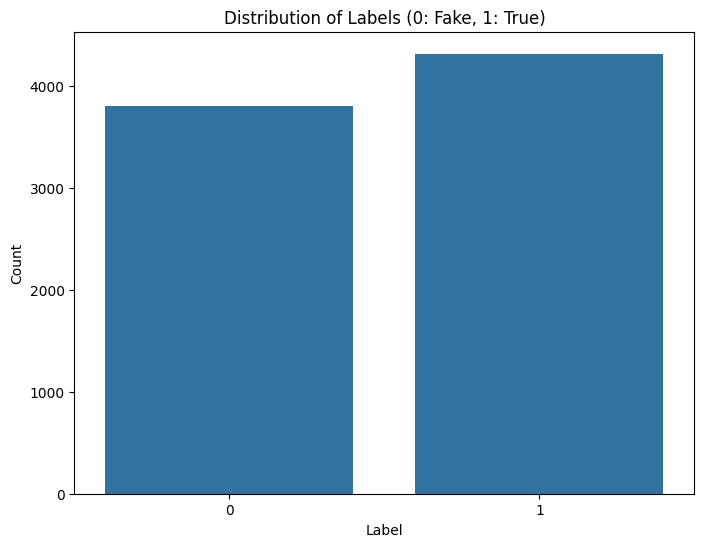

In [ ]:
# prompt: for the label 0 and 1 where 0 is fake and 1 is true, make a plot to visualize the count of the label of 0 and 1

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' DataFrame is already defined as in the previous code
# ... (previous code)

# Plotting the label counts
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data)
plt.title('Distribution of Labels (0: Fake, 1: True)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
# Preprocessing function
def preprocess(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ''.join([char for char in text if not char.isdigit()])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['cleaned_content'] = data['content'].apply(preprocess)

In [ ]:
# Splitting data
X = data['cleaned_content']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# TF-IDF Representation
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

# Logistic Regression on TF-IDF
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr.predict(X_test_tfidf)

# Evaluation for TF-IDF
print("TF-IDF Classification Report")
print(classification_report(y_test, y_pred_tfidf))

TF-IDF Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       764
           1       0.96      0.96      0.96       860

    accuracy                           0.96      1624
   macro avg       0.96      0.96      0.96      1624
weighted avg       0.96      0.96      0.96      1624



In [ ]:
# Word2Vec Representation
tokenized_train = [sentence.split() for sentence in X_train]
tokenized_test = [sentence.split() for sentence in X_test]

w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=2, workers=4)
embedding_matrix = np.zeros((len(w2v_model.wv.key_to_index) + 1, 100))

word_index = {word: idx for idx, word in enumerate(w2v_model.wv.key_to_index)}
for word, idx in word_index.items():
    embedding_matrix[idx] = w2v_model.wv[word]

In [ ]:
# Neural Network for Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences

def tokenize_text(tokenized_data, word_index, max_len=100):
    # Convert sentences to numerical indices
    sequences = [[word_index.get(word, 0) for word in sentence[:max_len]] for sentence in tokenized_data]

    # Pad sequences to ensure uniform length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    return padded_sequences

X_train_w2v = tokenize_text(tokenized_train, word_index)
X_test_w2v = tokenize_text(tokenized_test, word_index)

model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0], output_dim=100, weights=[embedding_matrix], trainable=False),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_w2v, y_train, epochs=5, batch_size=32, validation_split=0.2)

y_pred_w2v = (model.predict(X_test_w2v) > 0.5).astype(int)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6416 - loss: 0.6607 - val_accuracy: 0.8591 - val_loss: 0.4891
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8628 - loss: 0.4588 - val_accuracy: 0.8676 - val_loss: 0.3909
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8739 - loss: 0.3789 - val_accuracy: 0.8822 - val_loss: 0.3413
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8930 - loss: 0.3309 - val_accuracy: 0.8915 - val_loss: 0.3127
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8959 - loss: 0.3024 - val_accuracy: 0.8915 - val_loss: 0.2945
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
# Evaluation for Word2Vec
print("Word2Vec Classification Report")
print(classification_report(y_test, y_pred_w2v))

Word2Vec Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       764
           1       0.89      0.91      0.90       860

    accuracy                           0.90      1624
   macro avg       0.90      0.90      0.90      1624
weighted avg       0.90      0.90      0.90      1624



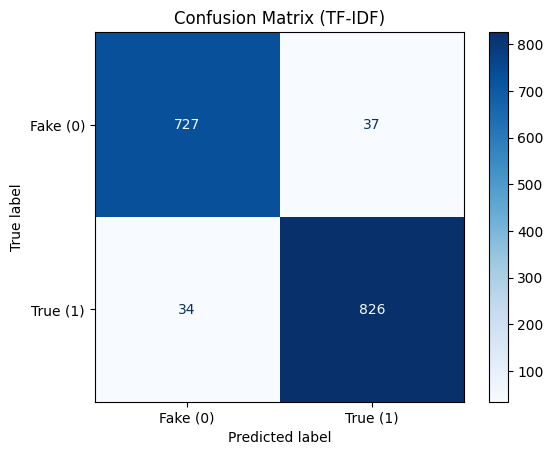

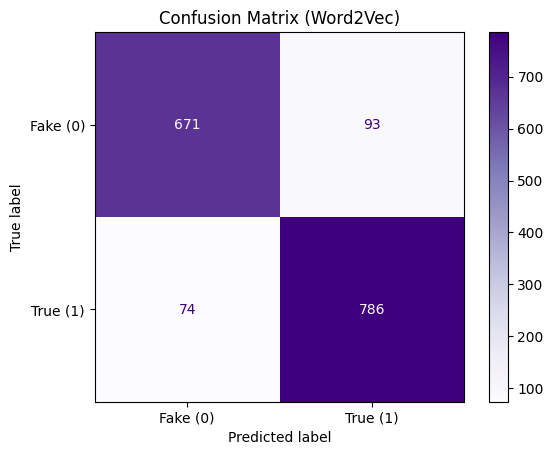

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix for TF-IDF
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=["Fake (0)", "True (1)"])
disp_tfidf.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (TF-IDF)")
plt.show()

# Confusion Matrix for Word2Vec
cm_w2v = confusion_matrix(y_test, y_pred_w2v)
disp_w2v = ConfusionMatrixDisplay(confusion_matrix=cm_w2v, display_labels=["Fake (0)", "True (1)"])
disp_w2v.plot(cmap=plt.cm.Purples, values_format='d')
plt.title("Confusion Matrix (Word2Vec)")
plt.show()
